<a href="https://colab.research.google.com/github/amanzoni1/MoE_Adapter_Routing_Analysis/blob/main/HELLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Uninstall the conflicting library
!pip uninstall -y torchvision

# 2. Force install the bleeding-edge Transformers (fixes the missing OLMoE class)
!pip install -U git+https://github.com/huggingface/transformers

# 3. Install core dependencies
!pip install -U torch accelerate peft datasets wandb

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-3rjc0v8g
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-3rjc0v8g
  Resolved https://github.com/huggingface/transformers to commit 461cfb14b847def4b8cbf0b039a544b820145699
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
!pip install -q transformers datasets peft accelerate wandb

In [3]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amanzoni1 (amanzoni1-n-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import torch
from transformers import OlmoeForCausalLM, AutoTokenizer

model_name = "allenai/OLMoE-1B-7B-0924"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = OlmoeForCausalLM.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto",
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.84G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [3]:
layer0 = model.model.layers[0]
print(layer0)

OlmoeDecoderLayer(
  (self_attn): OlmoeSdpaAttention(
    (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (q_norm): OlmoeRMSNorm((2048,), eps=1e-05)
    (k_norm): OlmoeRMSNorm((2048,), eps=1e-05)
  )
  (mlp): OlmoeSparseMoeBlock(
    (gate): Linear(in_features=2048, out_features=64, bias=False)
    (experts): ModuleList(
      (0-63): 64 x OlmoeMLP(
        (gate_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (up_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (down_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (act_fn): SiLUActivation()
      )
    )
  )
  (input_layernorm): OlmoeRMSNorm((2048,), eps=1e-05)
  (post_attention_layernorm): OlmoeRMSNorm((2048,), eps=1e-05)
)


In [4]:
# show attention-ish module names
for name, _ in model.named_modules():
    if any(x in name for x in ["q_proj","k_proj","v_proj","o_proj"]):
        print(name)
        break

# show gate module names
for name, _ in model.named_modules():
    if name.endswith("mlp.gate") or ".mlp.gate" in name:
        print(name)
        break

# show expert weight module names
cnt = 0
for name, _ in model.named_modules():
    if ".mlp.experts." in name and any(name.endswith(s) for s in [".w1",".w2",".w3"]):
        print(name)
        cnt += 1
        if cnt >= 20:
            break
print("printed", cnt, "expert weight module names")


model.layers.0.self_attn.q_proj
model.layers.0.mlp.gate
printed 0 expert weight module names


In [3]:
import torch
import os

# Global Configuration
CONFIG = {
    "batch_size": 32,
    "seq_len": 2048,
    "seed": 123,
    "output_dir": "./telemetry"
}

# Dataset Registry
DATASETS = {
    "gsm8k": {
        "path": "openai/gsm8k",
        "name": "main",
        "split": "train",
        "num_samples": 1000,
        "text_fn": lambda item: f"Question: {item['question']}\nAnswer: {item['answer']}"
    },
    "wikitext": {
        "path": "Salesforce/wikitext",
        "name": "wikitext-2-raw-v1",
        "split": "train",
        "num_samples": 1000,
        "text_fn": lambda item: item['text']
    },
    "alpaca": {
        "path": "sahil2801/CodeAlpaca-20k",
        "name": None,
        "split": "train",
        "num_samples": 1000,
        "text_fn": lambda item: f"{item['instruction']}\n{item['input']}\n{item['output']}"
    }
}

In [4]:
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
import os

class ProfilerEngine:
    def __init__(self, model, tokenizer, output_dir):
        self.model = model
        self.tokenizer = tokenizer
        self.output_dir = output_dir

        # Dynamic architecture detection
        if hasattr(model, "model") and hasattr(model.model, "layers"):
            self.layers = model.model.layers
        elif hasattr(model, "layers"): # Fallback for some architectures
            self.layers = model.layers
        else:
            raise ValueError("Could not automatically identify model layers.")

        self.num_layers = len(self.layers)
        self.num_experts = getattr(model.config, "num_experts", 64)
        self.top_k = getattr(model.config, "num_experts_per_tok", 8)
        self._current_attn_mask = None
        self.bucket_edges = [0, 64, 128, 256, 512, 1024, CONFIG["seq_len"]]
        self.num_buckets = len(self.bucket_edges) - 1
        self.hooks = []
        self.data_buffer = {}

        # Create output dir if not exists
        os.makedirs(self.output_dir, exist_ok=True)

    def _get_hook(self, layer_idx):
        def hook(module, input, output):
            logits = output[0] if isinstance(output, tuple) else output  # [T,E] or [B,S,E]

            # Normalize to [B,S,E] using attention_mask shape
            if self._current_attn_mask is None:
                raise RuntimeError("Need attention_mask for bucketing positions.")

            B, S = self._current_attn_mask.shape

            if logits.dim() == 2:
                T, E = logits.shape
                if T != B * S:
                    raise RuntimeError(f"Gate tokens {T} != B*S {B*S} (can't bucket safely)")
                logits3 = logits.view(B, S, E)
            elif logits.dim() == 3:
                B2, S2, E = logits.shape
                if (B2, S2) != (B, S):
                    raise RuntimeError(f"Gate shape {(B2,S2)} != mask shape {(B,S)}")
                logits3 = logits
            else:
                raise RuntimeError(f"Unexpected gate output shape: {tuple(logits.shape)}")

            if E != self.num_experts:
                raise RuntimeError(f"Gate last-dim {E} != num_experts {self.num_experts}")

            # Positions [0..S-1] repeated for each batch row
            pos = torch.arange(S, device=logits3.device).view(1, S).expand(B, S)  # [B,S]
            m = self._current_attn_mask.to(torch.bool)  # [B,S]

            # Select indices for real tokens only
            logits2d = logits3[m]     # [N, E]
            pos2d = pos[m]            # [N]

            _, idx = torch.topk(logits2d, k=self.top_k, dim=-1)  # [N,K]

            # Bucket and accumulate
            for bi in range(self.num_buckets):
                lo, hi = self.bucket_edges[bi], self.bucket_edges[bi + 1]
                bm = (pos2d >= lo) & (pos2d < hi)
                if not bm.any():
                    continue

                idx_b = idx[bm].reshape(-1)  # [N_bucket*K]
                counts = torch.bincount(idx_b, minlength=self.num_experts).cpu()

                self.data_buffer[layer_idx]["counts"][bi] += counts
                self.data_buffer[layer_idx]["total"][bi] += int(bm.sum().item()) * self.top_k

        return hook



    def attach_hooks(self):
        """Registers hooks dynamically based on model depth."""
        self.hooks = []
        self.data_buffer = {
            i: {
                "counts": [torch.zeros(self.num_experts, dtype=torch.long) for _ in range(self.num_buckets)],
                "total":  [0 for _ in range(self.num_buckets)],
            }
            for i in range(self.num_layers)
        }

        print(f"[System] Attaching probes to {self.num_layers} layers...")
        for i, layer in enumerate(self.layers):
            # Note: layer.mlp.gate is specific to OLMoE.
            # For other models (Mixtral/Qwen), this path may change (e.g., block_sparse_moe.gate).
            self.hooks.append(layer.mlp.gate.register_forward_hook(self._get_hook(i)))

    def detach_hooks(self):
        for h in self.hooks: h.remove()
        self.hooks = []
        print("[System] Hooks detached.")

    def run_dataset(self, dataset_key):
        """Executes profiling for a single dataset."""
        if dataset_key not in DATASETS:
            raise ValueError(f"Dataset '{dataset_key}' not found in registry.")

        cfg = DATASETS[dataset_key]
        print(f"\n[Profiler] Starting run: {dataset_key.upper()}")
        print(f"           Source: {cfg['path']} | Samples: {cfg['num_samples']}")

        # Load & Prep
        ds = load_dataset(cfg["path"], cfg.get("name"), split=cfg["split"])
        ds = ds.shuffle(seed=CONFIG["seed"]).select(range(cfg["num_samples"]))

        self.attach_hooks()
        try:
            batch_text = []
            pbar = tqdm(total=cfg["num_samples"], desc="Processing")

            for item in ds:
                text = cfg["text_fn"](item)
                if len(text) < 10:
                    continue

                batch_text.append(text)

                if len(batch_text) == CONFIG["batch_size"]:
                    self._process_batch(batch_text)
                    pbar.update(len(batch_text))
                    batch_text = []

            if batch_text:
                self._process_batch(batch_text)
                pbar.update(len(batch_text))

            pbar.close()
        finally:
            self.detach_hooks()

        return self._save(dataset_key)

    def _process_batch(self, batch_text):
        inputs = self.tokenizer(
            batch_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=CONFIG["seq_len"],
        ).to(self.model.device)

        # make mask visible to hooks
        self._current_attn_mask = inputs.get("attention_mask", None)

        with torch.no_grad():
            self.model(**inputs)

        self._current_attn_mask = None

    def _save(self, dataset_key):
        filename = os.path.join(self.output_dir, f"olmoe_activations_{dataset_key}.pt")

        final_data = {}
        for layer, data in self.data_buffer.items():
            final_data[layer] = {
                "counts": torch.stack(data["counts"]),
                "total": torch.tensor(data["total"])
            }

        torch.save(final_data, filename)
        print(f"[IO] Telemetry saved: {filename}")
        return filename

In [5]:
def run_profiling(targets):
    """
    Main entry point for profiling.
    Args:
        targets (list): List of dataset keys (e.g., ['gsm8k', 'wikitext'])
    """
    # Initialize Engine
    engine = ProfilerEngine(model, tokenizer, output_dir=CONFIG["output_dir"])

    generated_files = []

    for target in targets:
        try:
            path = engine.run_dataset(target)
            generated_files.append(path)
        except Exception as e:
            print(f"[Error] Failed to profile {target}: {str(e)}")

    return generated_files

In [6]:
output_files = run_profiling(targets=["gsm8k"])


[Profiler] Starting run: GSM8K
           Source: openai/gsm8k | Samples: 1000


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

[System] Attaching probes to 16 layers...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

[System] Hooks detached.
[IO] Telemetry saved: ./telemetry/olmoe_activations_gsm8k.pt


In [8]:
output_files = run_profiling(targets=["wikitext", "alpaca"])


[Profiler] Starting run: WIKITEXT
           Source: Salesforce/wikitext | Samples: 1000


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

[System] Attaching probes to 16 layers...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

[System] Hooks detached.
[IO] Telemetry saved: ./telemetry/olmoe_activations_wikitext.pt

[Profiler] Starting run: ALPACA
           Source: sahil2801/CodeAlpaca-20k | Samples: 1000


README.md:   0%|          | 0.00/147 [00:00<?, ?B/s]

code_alpaca_20k.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

[System] Attaching probes to 16 layers...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

[System] Hooks detached.
[IO] Telemetry saved: ./telemetry/olmoe_activations_alpaca.pt


In [9]:
from google.colab import files

def download_results(file_paths):
    print(f"\n[System] Preparing {len(file_paths)} files for download...")
    for path in file_paths:
        try:
            files.download(path)
        except Exception as e:
            print(f"[Error] Could not download {path}: {e}")

# Trigger download of files generated in previous step
download_results(output_files)


[System] Preparing 2 files for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import os

# Set clearer plot style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
from google.colab import files

# Clean up previous uploads to avoid duplicates if you re-run
for f in glob.glob("*.pt"):
    os.remove(f)

print("📂 Please upload your .pt files (wikitext, gsm8k, code_alpaca)...")
uploaded = files.upload()

print(f"\n✅ Uploaded {len(uploaded)} files.")
for fn in uploaded.keys():
    print(f"   - {fn}")

📂 Please upload your .pt files (wikitext, gsm8k, code_alpaca)...


Saving olmoe_activations_alpaca_bucketed.pt to olmoe_activations_alpaca_bucketed.pt
Saving olmoe_activations_gsm8k_bucketed.pt to olmoe_activations_gsm8k_bucketed.pt
Saving olmoe_activations_wikitext_bucketed.pt to olmoe_activations_wikitext_bucketed.pt

✅ Uploaded 3 files.
   - olmoe_activations_alpaca_bucketed.pt
   - olmoe_activations_gsm8k_bucketed.pt
   - olmoe_activations_wikitext_bucketed.pt


📊 Processing 3 datasets...

generating heatmaps...


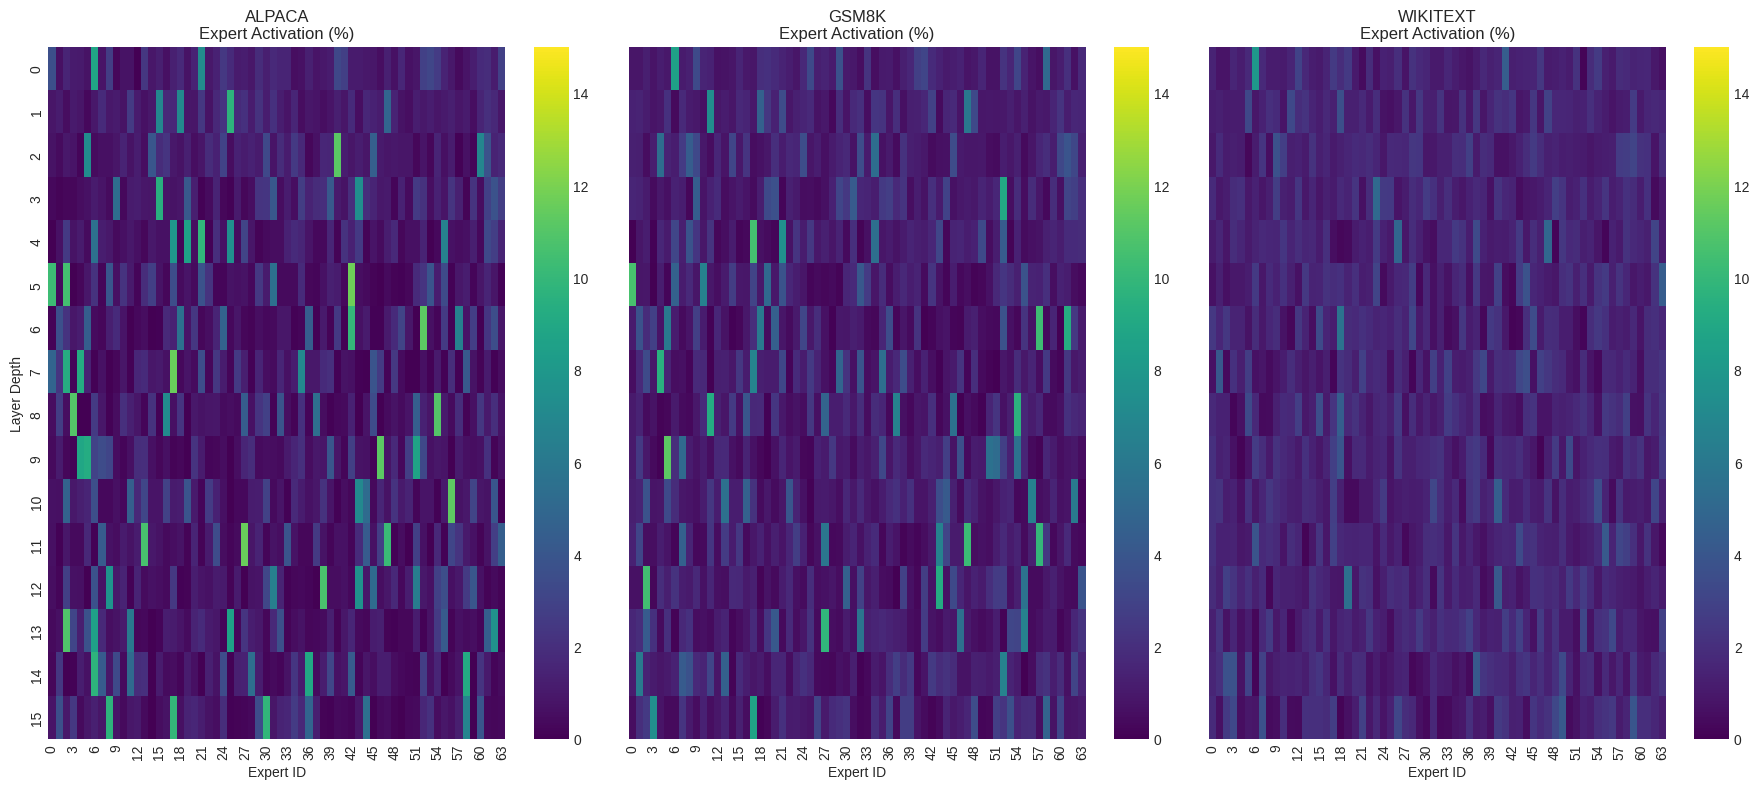

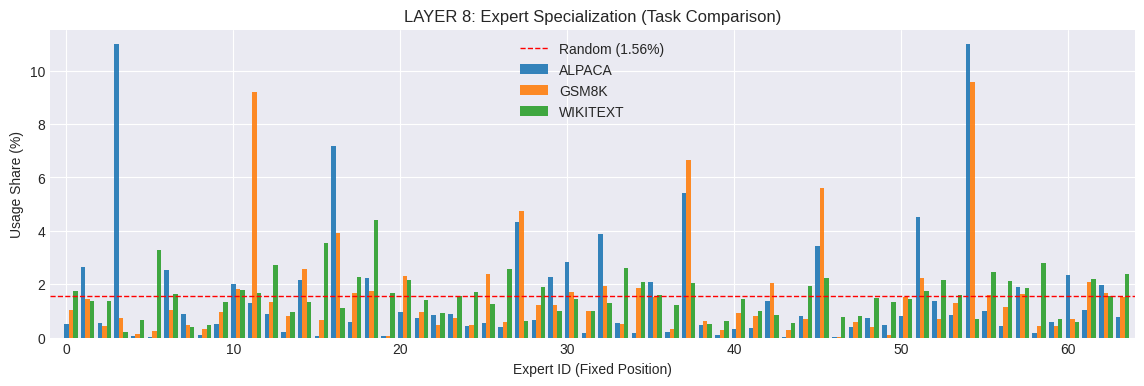

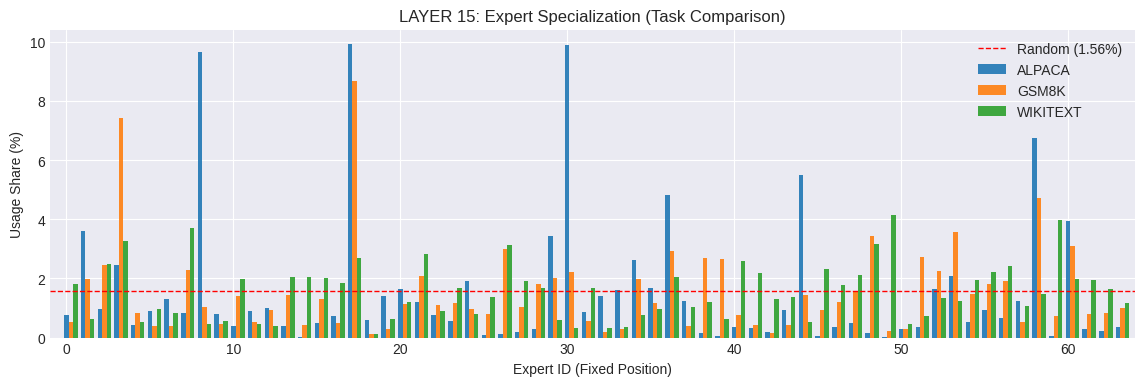


📈 STATS REPORT: ALPACA
Layer  | Top-1      | Top-8      | Experts for 90%    | Entropy   
----------------------------------------------------------------------
L00    |   8.8%      |  34.4%      | 48 experts        | 5.61
L01    |   9.7%      |  37.9%      | 49 experts        | 5.55
L02    |  11.2%      |  43.8%      | 45 experts        | 5.39
L03    |   9.5%      |  41.2%      | 40 experts        | 5.38
L04    |   9.8%      |  52.0%      | 37 experts        | 5.11
L05    |  11.7%      |  53.0%      | 32 experts        | 4.96
L06    |  11.2%      |  50.4%      | 32 experts        | 5.01
L07    |  11.6%      |  53.6%      | 32 experts        | 4.96
L08    |  11.0%      |  50.7%      | 34 experts        | 5.05
L09    |  11.2%      |  51.9%      | 36 experts        | 5.03
L10    |  11.3%      |  44.1%      | 39 experts        | 5.28
L11    |  11.6%      |  52.6%      | 35 experts        | 4.98
L12    |  10.7%      |  51.8%      | 35 experts        | 5.05
L13    |  10.9%      |  54.0%   

In [3]:
# ==========================================
# 1. LOAD & NORMALIZE DATA
# ==========================================
telemetry = {}
file_paths = glob.glob("*.pt")

if not file_paths:
    print("❌ No .pt files found! Did you run the upload cell?")
else:
    print(f"📊 Processing {len(file_paths)} datasets...")

    for path in file_paths:
        # Extract clean name (e.g., 'olmoe_activations_gsm8k.pt' -> 'gsm8k')
        name = path.split('_')[-1].replace('.pt', '')

        raw = torch.load(path)

        # Create empty matrix [16 Layers x 64 Experts]
        prob_matrix = torch.zeros((16, 64))

        for layer_idx, data in raw.items():
            # Sum counts across all batches
            total_counts = data["counts"].sum(dim=0).float()
            total_volume = data["total"].sum().float()

            # Normalize to percentage (0-100%)
            if total_volume > 0:
                prob_matrix[layer_idx] = (total_counts / total_volume) * 100

        telemetry[name] = prob_matrix

    # ==========================================
    # 2. VISUALIZATION: HEATMAPS (The "Fingerprints")
    # ==========================================
    datasets = sorted(list(telemetry.keys()))

    # Dynamic plot size based on number of datasets
    fig, axes = plt.subplots(1, len(datasets), figsize=(6 * len(datasets), 8), sharey=True)
    if len(datasets) == 1: axes = [axes] # Handle single case

    print("\ngenerating heatmaps...")
    for i, ds_name in enumerate(datasets):
        matrix = telemetry[ds_name].numpy()

        sns.heatmap(
            matrix,
            ax=axes[i],
            cmap="viridis",
            cbar=True,
            vmin=0, vmax=15 # Cap color at 15% to see contrast
        )
        axes[i].set_title(f"{ds_name.upper()}\nExpert Activation (%)")
        axes[i].set_xlabel("Expert ID")
        if i == 0: axes[i].set_ylabel("Layer Depth")

    plt.tight_layout()
    plt.show()

    # ==========================================
    # 3. VISUALIZATION: LAYER COMPARISON (Unsorted)
    # ==========================================
    # We look at Layer 8 (Mid-reasoning) and Layer 15 (Output)
    target_layers = [8, 15]

    for layer_idx in target_layers:
        plt.figure(figsize=(14, 4))

        x = np.arange(64)
        width = 0.8 / len(datasets)

        for i, ds_name in enumerate(datasets):
            usage = telemetry[ds_name][layer_idx].numpy()
            # Offset bars so they don't overlap
            plt.bar(x + (i * width), usage, width=width, label=ds_name.upper(), alpha=0.9)

        # Reference Line (Random Chance ~1.56%)
        plt.axhline(y=1.56, color='red', linestyle='--', linewidth=1, label="Random (1.56%)")

        plt.title(f"LAYER {layer_idx}: Expert Specialization (Task Comparison)")
        plt.xlabel("Expert ID (Fixed Position)")
        plt.ylabel("Usage Share (%)")
        plt.legend()
        plt.xlim(-1, 64)
        plt.show()

    # ==========================================
    # 4. STATS: EFFICIENCY & COVERAGE
    # ==========================================
    for ds_name in datasets:
        print(f"\n📈 STATS REPORT: {ds_name.upper()}")
        print(f"{'Layer':<6} | {'Top-1':<10} | {'Top-8':<10} | {'Experts for 90%':<18} | {'Entropy':<10}")
        print("-" * 70)

        matrix = telemetry[ds_name].numpy()

        for layer in range(16):
            probs = matrix[layer]
            sorted_probs = np.sort(probs)[::-1] # Descending

            top1 = sorted_probs[0]
            top8 = sorted_probs[:8].sum()

            # How many experts needed to cover 90% of traffic?
            cumsum = np.cumsum(sorted_probs)
            n_90 = np.searchsorted(cumsum, 90.0) + 1

            # Entropy (Spikiness)
            p_norm = probs / 100.0
            p_norm = p_norm[p_norm > 0]
            entropy = -np.sum(p_norm * np.log2(p_norm))

            print(f"L{layer:02d}    | {top1:5.1f}%      | {top8:5.1f}%      | {n_90:2d} experts        | {entropy:.2f}")

🔑 Available Dataset Keys: ['alpaca', 'gsm8k', 'wikitext']
🔄 Calculating Overlap for Layer 5...
   WIKITEXT   Top-8 Experts: {np.int64(6), np.int64(40), np.int64(43), np.int64(44), np.int64(55), np.int64(23), np.int64(28), np.int64(63)}
   GSM8K      Top-8 Experts: {np.int64(0), np.int64(32), np.int64(6), np.int64(10), np.int64(17), np.int64(19), np.int64(21), np.int64(55)}
   ALPACA     Top-8 Experts: {np.int64(0), np.int64(2), np.int64(8), np.int64(42), np.int64(17), np.int64(53), np.int64(21), np.int64(31)}


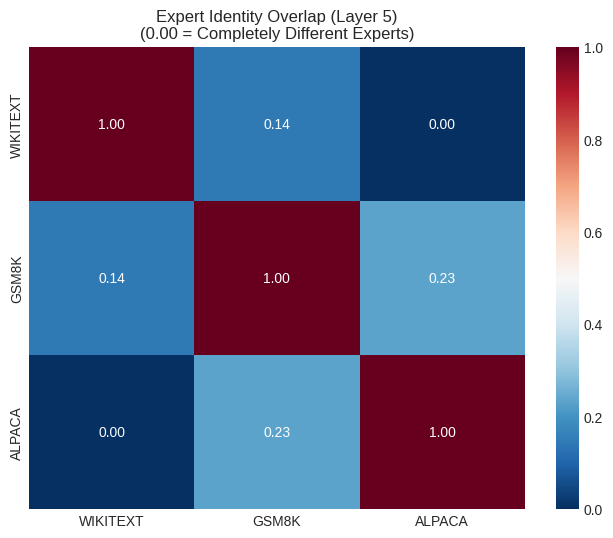

In [4]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Verify keys first (Debugging step)
print(f"🔑 Available Dataset Keys: {list(telemetry.keys())}")

# 2. Update the list to match the keys exactly
# 'alpaca' likely replaced 'code_alpaca' during the loading split
datasets = ["wikitext", "gsm8k", "alpaca"]
layer_to_check = 5

print(f"🔄 Calculating Overlap for Layer {layer_to_check}...")

# 3. Identify the "Hot Set" for each dataset
hot_sets = {}
for ds in datasets:
    if ds not in telemetry:
        print(f"⚠️ Warning: Key '{ds}' not found. Skipping.")
        continue

    # Get the global counts for this layer
    counts = telemetry[ds][layer_to_check].numpy()
    # Get indices of top 8
    top_8_indices = set(np.argsort(counts)[::-1][:8])
    hot_sets[ds] = top_8_indices
    # Use formatted print for cleaner output
    print(f"   {ds.upper():<10} Top-8 Experts: {top_8_indices}")

# 4. Build Jaccard Matrix
valid_datasets = [d for d in datasets if d in telemetry]
n = len(valid_datasets)
overlap_matrix = np.zeros((n, n))

for i, ds1 in enumerate(valid_datasets):
    for j, ds2 in enumerate(valid_datasets):
        set1 = hot_sets[ds1]
        set2 = hot_sets[ds2]

        # Jaccard = (Intersection) / (Union)
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))

        jaccard = intersection / union if union > 0 else 0
        overlap_matrix[i, j] = jaccard

# 5. Plot
if n > 0:
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        overlap_matrix,
        annot=True,
        fmt=".2f",
        xticklabels=[d.upper() for d in valid_datasets],
        yticklabels=[d.upper() for d in valid_datasets],
        cmap="RdBu_r",
        vmin=0, vmax=1
    )
    plt.title(f"Expert Identity Overlap (Layer {layer_to_check})\n(0.00 = Completely Different Experts)")
    plt.show()

In [5]:
import torch
import pandas as pd
import numpy as np

# Settings
coverage_thresholds = [50, 80, 90, 95] # Dynamic thresholds
top_k_check = [2, 4, 8, 16]            # Static thresholds

results = []

print("DATA ANALYSIS: Layer-by-Layer Sparsity Check")
print("="*60)

for layer_idx in range(16):
    for ds_name in datasets: # ["wikitext", "gsm8k", "alpaca"]
        if ds_name not in telemetry: continue

        # Get data
        probs = telemetry[ds_name][layer_idx].numpy()
        sorted_probs = np.sort(probs)[::-1] # Descending order
        cumsum = np.cumsum(sorted_probs)

        # 1. Dynamic Coverage (How many experts to reach X%?)
        n_experts = {}
        for t in coverage_thresholds:
            # searchsorted returns index, so +1 gives count
            count = np.searchsorted(cumsum, t) + 1
            n_experts[f"Exp_for_{t}%"] = count

        # 2. Static Top-K (What % do they cover?)
        k_coverage = {}
        for k in top_k_check:
            cov = sorted_probs[:k].sum()
            k_coverage[f"Top{k}_Share"] = round(cov, 1)

        # 3. Entropy (Sparsity Metric)
        p_norm = probs[probs > 0] / 100.0
        entropy = -np.sum(p_norm * np.log2(p_norm))

        # Collect Row
        row = {
            "Layer": layer_idx,
            "Dataset": ds_name,
            "Entropy": round(entropy, 2),
            **n_experts, # Unpack dynamic counts
            **k_coverage # Unpack static shares
        }
        results.append(row)

# Create DataFrame
df = pd.DataFrame(results)

# --- ANALYSIS 1: The "Code vs Math" Gap ---
# We want to see WHICH layers are most different
print("\n🔎 SPARSITY GAP (Experts needed for 90% Coverage)")
print(f"{'Layer':<5} | {'Math':<5} | {'Code':<5} | {'Gap (Math - Code)':<15}")
print("-" * 45)

math_df = df[df["Dataset"] == "openai/gsm8k"].set_index("Layer")
code_df = df[df["Dataset"] == "alpaca"].set_index("Layer")

for l in range(16):
    m = math_df.loc[l, "Exp_for_90%"]
    c = code_df.loc[l, "Exp_for_90%"]
    gap = m - c

    # Highlight big differences
    marker = "🔥🔥" if gap > 10 else ""
    print(f"L{l:02d}   | {m:<5} | {c:<5} | {gap:<5} {marker}")

# --- ANALYSIS 2: Full Data Export ---
# Save detailed report to check later
df.to_csv("olmoe_layer_sparsity_report.csv", index=False)
print("\n✅ Full report saved to 'olmoe_layer_sparsity_report.csv'")

DATA ANALYSIS: Layer-by-Layer Sparsity Check

🔎 SPARSITY GAP (Experts needed for 90% Coverage)
Layer | Math  | Code  | Gap (Math - Code)
---------------------------------------------


KeyError: 0

In [9]:
import torch
import json
import numpy as np

# Settings
TARGET_COVERAGE = 35.0  # Try 35% mass (usually captures the "Core" experts)
STATIC_K = 8            # Baseline

configs = {}

print(f"⚙️ GENERATING ADAPTIVE CONFIGS (Target: {TARGET_COVERAGE}% Coverage)")
print("="*60)
print(f"{'Layer':<5} | {'Math (Count)':<12} | {'Code (Count)':<12} | {'Savings (Code)'}")
print("-" * 60)

# We will build two lists: one for Math, one for Code
math_experts_map = {}
code_experts_map = {}

total_math_experts = 0
total_code_experts = 0

for layer_idx in range(16):
    # 1. Math Analysis
    probs_m = telemetry['gsm8k'][layer_idx].numpy()
    # Get indices that sort the array
    sorted_idx_m = np.argsort(probs_m)[::-1]
    sorted_val_m = probs_m[sorted_idx_m]

    # Cumulative Sum to find cut-off
    cumsum_m = np.cumsum(sorted_val_m)
    cutoff_m = np.searchsorted(cumsum_m, TARGET_COVERAGE) + 1
    # Keep at least 2 experts to be safe
    cutoff_m = max(2, cutoff_m)

    selected_m = sorted_idx_m[:cutoff_m].tolist()
    math_experts_map[str(layer_idx)] = selected_m
    total_math_experts += len(selected_m)

    # 2. Code Analysis
    probs_c = telemetry['alpaca'][layer_idx].numpy()
    sorted_idx_c = np.argsort(probs_c)[::-1]
    sorted_val_c = probs_c[sorted_idx_c]

    cumsum_c = np.cumsum(sorted_val_c)
    cutoff_c = np.searchsorted(cumsum_c, TARGET_COVERAGE) + 1
    cutoff_c = max(2, cutoff_c)

    selected_c = sorted_idx_c[:cutoff_c].tolist()
    code_experts_map[str(layer_idx)] = selected_c
    total_code_experts += len(selected_c)

    # Print comparison
    savings = total_math_experts - total_code_experts if layer_idx == 0 else (len(selected_m) - len(selected_c))
    print(f"L{layer_idx:02d}   | {len(selected_m):<12} | {len(selected_c):<12} | -{len(selected_m) - len(selected_c)}")

print("="*60)
print(f"TOTAL EXPERTS TRAINED (Target {TARGET_COVERAGE}%):")
print(f"  Math: {total_math_experts} (Avg {total_math_experts/16:.1f}/layer)")
print(f"  Code: {total_code_experts} (Avg {total_code_experts/16:.1f}/layer)")
print(f"  Baseline (Top-8): {8*16}")

# Save to JSON
final_configs = {
    "math_config": math_experts_map,
    "code_config": code_experts_map
}

with open("hellora_adaptive_config.json", "w") as f:
    json.dump(final_configs, f, indent=4)

print("\n✅ Config saved to 'hellora_adaptive_config.json'")

⚙️ GENERATING ADAPTIVE CONFIGS (Target: 35.0% Coverage)
Layer | Math (Count) | Code (Count) | Savings (Code)
------------------------------------------------------------
L00   | 9            | 9            | -0
L01   | 10           | 7            | -3
L02   | 9            | 6            | -3
L03   | 9            | 7            | -2
L04   | 7            | 5            | -2
L05   | 7            | 4            | -3
L06   | 5            | 5            | -0
L07   | 7            | 4            | -3
L08   | 5            | 5            | -0
L09   | 6            | 4            | -2
L10   | 8            | 6            | -2
L11   | 5            | 4            | -1
L12   | 6            | 5            | -1
L13   | 6            | 4            | -2
L14   | 9            | 5            | -4
L15   | 8            | 4            | -4
TOTAL EXPERTS TRAINED (Target 35.0%):
  Math: 116 (Avg 7.2/layer)
  Code: 84 (Avg 5.2/layer)
  Baseline (Top-8): 128

✅ Config saved to 'hellora_adaptive_config.json'


📊 PARETO ANALYSIS: Cost vs. Coverage

Analyzing GSM8K...
Layer  | 20% Cov  | 40% Cov  | 60% Cov  | 80% Cov  | 95% Cov 
---------------------------------------------------------------------------
L00    | 4  exp    | 12 exp    | 24 exp    | 40 exp    | 57 exp
L01    | 4  exp    | 12 exp    | 24 exp    | 39 exp    | 56 exp
L02    | 5  exp    | 11 exp    | 21 exp    | 37 exp    | 54 exp
L03    | 4  exp    | 11 exp    | 21 exp    | 35 exp    | 53 exp
L04    | 3  exp    | 8  exp    | 18 exp    | 33 exp    | 49 exp
L05    | 3  exp    | 8  exp    | 17 exp    | 31 exp    | 48 exp
L06    | 3  exp    | 6  exp    | 13 exp    | 26 exp    | 45 exp
L07    | 3  exp    | 8  exp    | 17 exp    | 31 exp    | 48 exp
L08    | 3  exp    | 7  exp    | 16 exp    | 30 exp    | 48 exp
L09    | 3  exp    | 8  exp    | 17 exp    | 33 exp    | 50 exp
L10    | 4  exp    | 9  exp    | 19 exp    | 35 exp    | 53 exp
L11    | 2  exp    | 6  exp    | 15 exp    | 30 exp    | 49 exp
L12    | 3  exp    | 8  exp    | 16 e

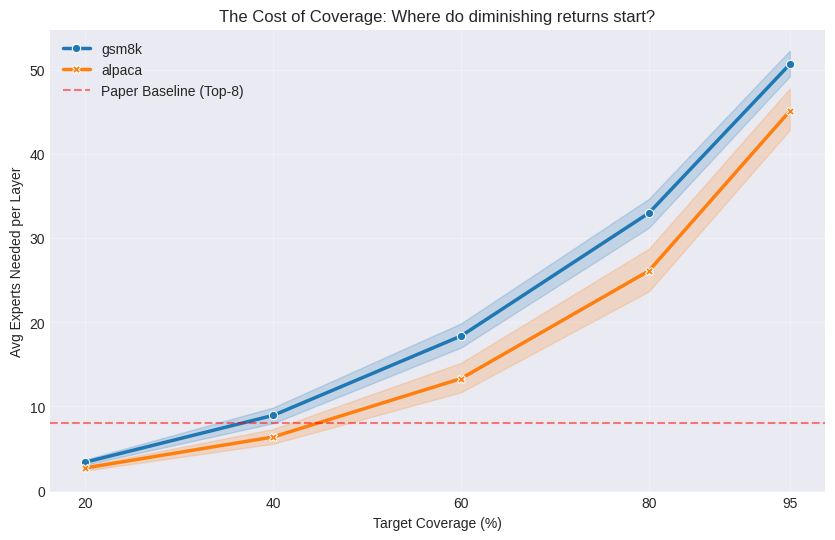

In [10]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the spectrum of ambition
thresholds = [20, 40, 60, 80, 95]

print("📊 PARETO ANALYSIS: Cost vs. Coverage")
print("="*60)

results = []

for ds_name in ["gsm8k", "alpaca"]:
    if ds_name not in telemetry: continue

    print(f"\nAnalyzing {ds_name.upper()}...")
    print(f"{'Layer':<6} | {'20% Cov':<8} | {'40% Cov':<8} | {'60% Cov':<8} | {'80% Cov':<8} | {'95% Cov':<8}")
    print("-" * 75)

    for layer in range(16):
        probs = telemetry[ds_name][layer].numpy()
        sorted_probs = np.sort(probs)[::-1] # Descending
        cumsum = np.cumsum(sorted_probs)

        # Calculate K needed for each threshold
        counts = []
        for t in thresholds:
            k = np.searchsorted(cumsum, t) + 1
            counts.append(k)

            # Save for plotting
            results.append({
                "Dataset": ds_name,
                "Layer": layer,
                "Target_Coverage": t,
                "Experts_Needed": k
            })

        # Print Row
        row_str = f"L{layer:02d}    | {counts[0]:<2} exp    | {counts[1]:<2} exp    | {counts[2]:<2} exp    | {counts[3]:<2} exp    | {counts[4]:<2} exp"
        print(row_str)

# ==========================================
# VISUALIZATION: The "Cost Curve"
# ==========================================
df = pd.DataFrame(results)

# We want to see the "Diminishing Returns"
# Plot Average Experts Needed vs Coverage
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df,
    x="Target_Coverage",
    y="Experts_Needed",
    hue="Dataset",
    style="Dataset",
    markers=True,
    dashes=False,
    linewidth=2.5
)

# Draw the "Baseline" (Top-8)
plt.axhline(y=8, color='red', linestyle='--', alpha=0.5, label="Paper Baseline (Top-8)")

plt.title("The Cost of Coverage: Where do diminishing returns start?")
plt.xlabel("Target Coverage (%)")
plt.ylabel("Avg Experts Needed per Layer")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(thresholds)
plt.show()

In [11]:
import torch
import numpy as np

# Define the "Coverage Sweep"
sweep_thresholds = [30, 40, 50, 60, 70]

# 1. DEBUG: Check what is actually inside
print(f"🔑 DEBUG: Found keys in telemetry: {list(telemetry.keys())}")

print("\n🔮 COVERAGE STRATEGY SIMULATION")
print("="*80)
print(f"{'Dataset':<12} | {'Cov%':<4} | {'Total Exp':<10} | {'Avg K':<6} | {'Min K':<6} | {'Max K':<6} | {'vs Baseline'}")
print("-" * 80)

# 2. Dynamic Loop: Iterate through WHATEVER is loaded
for ds_name in telemetry.keys():

    for target in sweep_thresholds:
        layer_ks = []

        for layer in range(16):
            probs = telemetry[ds_name][layer].numpy()
            sorted_val = np.sort(probs)[::-1]
            cumsum = np.cumsum(sorted_val)

            # Find K needed to hit target
            k = np.searchsorted(cumsum, target) + 1
            k = max(2, k) # Safety floor
            layer_ks.append(k)

        total_k = sum(layer_ks)
        avg_k = total_k / 16
        min_k = min(layer_ks)
        max_k = max(layer_ks)

        # Baseline Comparison
        diff = total_k - 128
        diff_str = f"{diff:+d}" if diff != 0 else "SAME"

        # Highlight the "Sweet Spot" (close to 128)
        marker = "👈" if abs(diff) < 5 else ""

        print(f"{ds_name:<12} | {target}%  | {total_k:<10} | {avg_k:<6.1f} | {min_k:<6} | {max_k:<6} | {diff_str:<10} {marker}")

    print("-" * 80)

🔑 DEBUG: Found keys in telemetry: ['alpaca', 'gsm8k', 'wikitext']

🔮 COVERAGE STRATEGY SIMULATION
Dataset      | Cov% | Total Exp  | Avg K  | Min K  | Max K  | vs Baseline
--------------------------------------------------------------------------------
alpaca       | 30%  | 68         | 4.2    | 3      | 7      | -60        
alpaca       | 40%  | 102        | 6.4    | 5      | 11     | -26        
alpaca       | 50%  | 148        | 9.2    | 7      | 15     | +20        
alpaca       | 60%  | 213        | 13.3   | 10     | 22     | +85        
alpaca       | 70%  | 298        | 18.6   | 15     | 29     | +170       
--------------------------------------------------------------------------------
gsm8k        | 30%  | 91         | 5.7    | 4      | 8      | -37        
gsm8k        | 40%  | 143        | 8.9    | 6      | 12     | +15        
gsm8k        | 50%  | 208        | 13.0   | 9      | 18     | +80        
gsm8k        | 60%  | 294        | 18.4   | 13     | 24     | +166       


In [12]:
import numpy as np
import json

thresholds = [30, 40, 45, 50, 60]  # Focus promising range

print("DYNAMIC COVERAGE CONFIG GENERATOR")
print("="*70)
print(f"{'Dataset':<12} | {'Threshold':<10} | {'Total Experts':<14} | {'Avg per Layer':<14} | {'% vs Fixed-8'}")
print("-"*70)

configs = {}  # For saving

for ds_name in telemetry.keys():
    configs[ds_name] = {}
    for thresh in thresholds:
        hot_map = {}
        layer_ks = []
        for layer in range(16):
            probs = telemetry[ds_name][layer].numpy()
            sorted_idx = np.argsort(probs)[::-1]
            cumsum = np.cumsum(probs[sorted_idx])
            k = np.searchsorted(cumsum, thresh) + 1
            k = max(2, k)
            layer_ks.append(k)
            hot_map[layer] = sorted_idx[:k].tolist()

        total = sum(layer_ks)
        avg = total / 16
        pct_vs_8 = (total - 128) / 128 * 100

        print(f"{ds_name:<12} | {thresh}%       | {total:<14} | {avg:<14.1f} | {pct_vs_8:+.1f}%")

        configs[ds_name][f"cov_{thresh}pct"] = hot_map

    print("-"*70)

# Save all (easy fine-tune switch)
with open("dynamic_hot_configs.json", "w") as f:
    json.dump(configs, f, indent=4)

print("Configs saved → use in get_target_modules() for LoraConfig")

DYNAMIC COVERAGE CONFIG GENERATOR
Dataset      | Threshold  | Total Experts  | Avg per Layer  | % vs Fixed-8
----------------------------------------------------------------------
alpaca       | 30%       | 68             | 4.2            | -46.9%
alpaca       | 40%       | 102            | 6.4            | -20.3%
alpaca       | 45%       | 123            | 7.7            | -3.9%
alpaca       | 50%       | 148            | 9.2            | +15.6%
alpaca       | 60%       | 213            | 13.3           | +66.4%
----------------------------------------------------------------------
gsm8k        | 30%       | 91             | 5.7            | -28.9%
gsm8k        | 40%       | 143            | 8.9            | +11.7%
gsm8k        | 45%       | 174            | 10.9           | +35.9%
gsm8k        | 50%       | 208            | 13.0           | +62.5%
gsm8k        | 60%       | 294            | 18.4           | +129.7%
---------------------------------------------------------------------

In [15]:
import torch, glob
import numpy as np
import pandas as pd

bucket_edges = [0, 64, 128, 256, 512, 1024, 2048]  # keep consistent with profiler

def bucket_name(i):
    return f"{bucket_edges[i]}-{bucket_edges[i+1]}"

def compute_bucket_stats(path):
    raw = torch.load(path, map_location="cpu")
    num_layers = len(raw)
    num_buckets = raw[0]["counts"].shape[0]
    num_experts = raw[0]["counts"].shape[1]

    rows = []
    for b in range(num_buckets):
        top1_list, top8_list, ent_list = [], [], []
        for l in range(num_layers):
            counts = raw[l]["counts"][b].float()          # [E]
            total = float(raw[l]["total"][b].item())      # scalar
            if total <= 0:
                continue
            p = counts / total                            # selection prob (sums to ~1)
            p_np = p.numpy()

            # Top-1, Top-8 share (percent)
            sorted_p = np.sort(p_np)[::-1]
            top1_list.append(sorted_p[0] * 100)
            top8_list.append(sorted_p[:8].sum() * 100)

            # Entropy
            p_pos = p_np[p_np > 0]
            ent = float(-(p_pos * np.log2(p_pos)).sum())
            ent_list.append(ent)

        rows.append({
            "bucket": bucket_name(b),
            "top1_mean": np.mean(top1_list),
            "top8_mean": np.mean(top8_list),
            "entropy_mean": np.mean(ent_list),
        })
    return pd.DataFrame(rows)

# Load all bucketed files in telemetry dir
paths = sorted(glob.glob("./*_bucketed.pt"))
if not paths:
    print("No *_bucketed.pt files found.")
else:
    all_dfs = []
    for p in paths:
        ds = p.split("_")[-2]  # crude: ..._gsm8k_bucketed.pt -> gsm8k
        df = compute_bucket_stats(p)
        df.insert(0, "dataset", ds)
        all_dfs.append(df)

    out = pd.concat(all_dfs, ignore_index=True)
    print(out)
    out.to_csv("./telemetry/bucket_stats_summary.csv", index=False)
    print("Saved -> ./telemetry/bucket_stats_summary.csv")


     dataset     bucket  top1_mean  top8_mean  entropy_mean
0     alpaca       0-64  10.895165  48.623093      5.121886
1     alpaca     64-128  10.633671  49.837151      5.076152
2     alpaca    128-256  10.090313  47.346275      5.138513
3     alpaca    256-512   9.940459  46.411659      5.162747
4     alpaca   512-1024   9.268467  46.244675      4.983951
5     alpaca  1024-2048        NaN        NaN           NaN
6      gsm8k       0-64   7.795483  32.041016      5.633256
7      gsm8k     64-128  10.133885  46.081703      5.257138
8      gsm8k    128-256  10.389326  48.883678      5.171321
9      gsm8k    256-512  10.419147  49.640999      5.135834
10     gsm8k   512-1024        NaN        NaN           NaN
11     gsm8k  1024-2048        NaN        NaN           NaN
12  wikitext       0-64   5.147349  25.326559      5.811281
13  wikitext     64-128   4.490616  24.639761      5.804390
14  wikitext    128-256   4.219787  23.911293      5.818960
15  wikitext    256-512   4.073862  23.4

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
import torch, numpy as np
from collections import defaultdict

def topk_set(counts, k=8):
    idx = np.argsort(counts)[::-1][:k]
    return set(idx.tolist())

def jaccard(a, b):
    return len(a & b) / max(1, len(a | b))

path = "./olmoe_activations_gsm8k_bucketed.pt"
raw = torch.load(path, map_location="cpu")

early_b = 0   # 0-64
late_b  = 4   # 512-1024  (adjust if you want 1024-2048 etc.)

layer_j = []
for l in range(16):
    c1 = raw[l]["counts"][early_b].numpy()
    c2 = raw[l]["counts"][late_b].numpy()
    layer_j.append(jaccard(topk_set(c1, 8), topk_set(c2, 8)))

print("Avg Jaccard early vs late (top-8 sets):", sum(layer_j)/len(layer_j))
print("Per-layer:", [round(x, 2) for x in layer_j])


Avg Jaccard early vs late (top-8 sets): 0.07573260073260073
Per-layer: [0.14, 0.07, 0.23, 0.14, 0.0, 0.0, 0.14, 0.0, 0.0, 0.0, 0.14, 0.14, 0.07, 0.07, 0.07, 0.0]


In [4]:
import torch, numpy as np, json

path = "./olmoe_activations_gsm8k_bucketed.pt"
raw = torch.load(path, map_location="cpu")

TOPK = 8
bucket_edges = [0,64,128,256,512,1024,2048]
# choose “late” bucket range: 64-512 => buckets 1,2,3
late_buckets = [1,2,3]

hot = {}
for l in range(16):
    counts = sum(raw[l]["counts"][b] for b in late_buckets).float()  # [E]
    top_idx = torch.topk(counts, k=TOPK).indices.tolist()
    hot[l] = top_idx

with open("./gsm8k_hot_late_64_512.json","w") as f:
    json.dump(hot, f, indent=2)

print("Saved ./gsm8k_hot_late_64_512.json")
print("Example L0:", hot[0])


Saved ./gsm8k_hot_late_64_512.json
Example L0: [6, 58, 29, 9, 54, 25, 40, 52]


In [5]:
def coverage_for_hot(raw, hot, buckets):
    cov = []
    for l in range(16):
        counts = sum(raw[l]["counts"][b] for b in buckets).float()
        total  = sum(float(raw[l]["total"][b].item()) for b in buckets)
        if total <= 0:
            cov.append(np.nan); continue
        cov.append((counts[hot[l]].sum().item() / total) * 100)
    return np.nanmean(cov), cov

mean_cov, per_layer = coverage_for_hot(raw, hot, late_buckets)
print("Avg coverage in 64-512 using HOT_LATE:", mean_cov)
print("Per-layer:", [round(x,1) for x in per_layer])


Avg coverage in 64-512 using HOT_LATE: 47.183568960796315
Per-layer: [35.3, 38.4, 38.3, 40.9, 48.6, 47.1, 55.7, 50.2, 55.0, 54.0, 47.3, 56.9, 50.6, 50.9, 41.2, 44.6]


In [6]:
# Full-sequence hot map = sum over ALL buckets that have tokens
all_buckets = [0,1,2,3,4,5]  # but buckets 4-5 probably empty; ok

hot_full = {}
for l in range(16):
    counts = sum(raw[l]["counts"][b] for b in all_buckets).float()
    hot_full[l] = torch.topk(counts, k=8).indices.tolist()

mean_cov_full_on_late, per_layer_full = coverage_for_hot(raw, hot_full, late_buckets)

print("Avg coverage in 64-512 using HOT_FULL:", mean_cov_full_on_late)
print("Per-layer:", [round(x,1) for x in per_layer_full])


Avg coverage in 64-512 using HOT_FULL: 46.531549987114644
Per-layer: [34.8, 38.4, 38.0, 39.6, 48.4, 47.1, 54.9, 50.1, 54.0, 54.0, 46.4, 54.8, 49.9, 50.0, 39.8, 44.1]


In [ ]:
import os
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
from typing import Callable, Dict, Optional, List, Any, Union


class ProfilerEngine:
    """
    Profiles MoE router/gate activations by counting top-k selected experts per token.

    Supports:
      - Global aggregation (no buckets): counts per layer over all real tokens.
      - Position buckets: counts per layer, split by token position ranges.

    Saves a dict keyed by layer_idx:
      - if bucket_edges is None:
          {"counts": Tensor[E], "total": Tensor[()] }   # total selections
      - else:
          {"counts": Tensor[B,E], "total": Tensor[B] }  # B buckets
    """

    def __init__(
        self,
        model,
        tokenizer,
        output_dir: str,
        seq_len: int,
        bucket_edges: Optional[List[int]] = None,
        gate_getter: Optional[Callable[[Any], Any]] = None,
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.output_dir = output_dir
        self.seq_len = seq_len

        # Dynamic architecture detection
        if hasattr(model, "model") and hasattr(model.model, "layers"):
            self.layers = model.model.layers
        elif hasattr(model, "layers"):
            self.layers = model.layers
        else:
            raise ValueError("Could not automatically identify model layers.")

        self.num_layers = len(self.layers)
        self.num_experts = getattr(model.config, "num_experts", 64)
        self.top_k = getattr(model.config, "num_experts_per_tok", 8)

        # Buckets
        self.bucket_edges = bucket_edges
        if self.bucket_edges is not None:
            if self.bucket_edges[0] != 0:
                raise ValueError("bucket_edges must start with 0.")
            if self.bucket_edges[-1] < self.seq_len:
                raise ValueError("bucket_edges last edge must be >= seq_len.")
            self.num_buckets = len(self.bucket_edges) - 1
        else:
            self.num_buckets = 0

        self._current_attn_mask: Optional[torch.Tensor] = None
        self.hooks = []
        self.data_buffer: Dict[int, Dict[str, Any]] = {}

        # Gate getter: how to reach the gate module in each layer
        # Default for OLMoE: layer.mlp.gate
        self.gate_getter = gate_getter or (lambda layer: layer.mlp.gate)

        os.makedirs(self.output_dir, exist_ok=True)

    def _init_buffer(self):
        if self.bucket_edges is None:
            self.data_buffer = {
                i: {
                    "counts": torch.zeros(self.num_experts, dtype=torch.long),
                    "total": 0,  # total selections
                }
                for i in range(self.num_layers)
            }
        else:
            self.data_buffer = {
                i: {
                    "counts": torch.zeros(self.num_buckets, self.num_experts, dtype=torch.long),
                    "total": [0 for _ in range(self.num_buckets)],
                }
                for i in range(self.num_layers)
            }

    def _get_hook(self, layer_idx: int):
        def hook(module, input, output):
            logits = output[0] if isinstance(output, tuple) else output

            if self._current_attn_mask is None:
                raise RuntimeError("attention_mask not set; cannot mask padding.")

            B, S = self._current_attn_mask.shape
            m = self._current_attn_mask.to(torch.bool)  # [B,S]

            # Normalize router logits to [B,S,E]
            if logits.dim() == 2:
                T, E = logits.shape
                if T != B * S:
                    raise RuntimeError(f"Gate tokens {T} != B*S {B*S} (cannot align positions)")
                logits3 = logits.view(B, S, E)
            elif logits.dim() == 3:
                B2, S2, E = logits.shape
                if (B2, S2) != (B, S):
                    raise RuntimeError(f"Gate shape {(B2,S2)} != mask shape {(B,S)}")
                logits3 = logits
            else:
                raise RuntimeError(f"Unexpected gate output shape: {tuple(logits.shape)}")

            if E != self.num_experts:
                raise RuntimeError(f"Gate last-dim {E} != num_experts {self.num_experts}")

            # Select only real tokens
            logits2d = logits3[m]  # [N,E]
            if logits2d.numel() == 0:
                return

            _, idx = torch.topk(logits2d, k=self.top_k, dim=-1)  # [N,K]

            if self.bucket_edges is None:
                # Global aggregation
                counts = torch.bincount(idx.reshape(-1), minlength=self.num_experts).cpu()
                self.data_buffer[layer_idx]["counts"] += counts
                self.data_buffer[layer_idx]["total"] += int(idx.shape[0]) * self.top_k
            else:
                # Bucketed aggregation by token position
                pos = torch.arange(S, device=logits3.device).view(1, S).expand(B, S)  # [B,S]
                pos2d = pos[m]  # [N]

                for bi in range(self.num_buckets):
                    lo, hi = self.bucket_edges[bi], self.bucket_edges[bi + 1]
                    bm = (pos2d >= lo) & (pos2d < hi)
                    if not bm.any():
                        continue

                    idx_b = idx[bm].reshape(-1)
                    counts = torch.bincount(idx_b, minlength=self.num_experts).cpu()
                    self.data_buffer[layer_idx]["counts"][bi] += counts
                    self.data_buffer[layer_idx]["total"][bi] += int(bm.sum().item()) * self.top_k

        return hook

    def attach_hooks(self):
        self.detach_hooks()
        self._init_buffer()

        print(f"[System] Attaching probes to {self.num_layers} layers...")
        for i, layer in enumerate(self.layers):
            gate = self.gate_getter(layer)
            self.hooks.append(gate.register_forward_hook(self._get_hook(i)))

    def detach_hooks(self):
        for h in self.hooks:
            try:
                h.remove()
            except Exception:
                pass
        self.hooks = []

    def _process_batch(self, batch_text: List[str]):
        inputs = self.tokenizer(
            batch_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=self.seq_len,
        ).to(self.model.device)

        self._current_attn_mask = inputs.get("attention_mask", None)

        with torch.no_grad():
            self.model(**inputs)

        self._current_attn_mask = None

    def run_dataset(
        self,
        dataset_cfg: Dict[str, Any],
        seed: int = 123,
        batch_size: int = 32,
        num_samples: int = 1000,
        dataset_key: str = "dataset",
        force_redownload: bool = False,
    ) -> str:
        print(f"\n[Profiler] Starting run: {dataset_key.upper()}")
        print(f"           Source: {dataset_cfg['path']} | Samples: {num_samples}")

        dl_mode = "force_redownload" if force_redownload else None
        ds = load_dataset(dataset_cfg["path"], dataset_cfg.get("name"), split=dataset_cfg["split"], download_mode=dl_mode)
        ds = ds.shuffle(seed=seed).select(range(num_samples))

        self.attach_hooks()
        try:
            batch_text = []
            pbar = tqdm(total=num_samples, desc="Processing")

            for item in ds:
                text = dataset_cfg["text_fn"](item)
                if len(text) < 10:
                    continue

                batch_text.append(text)
                if len(batch_text) == batch_size:
                    self._process_batch(batch_text)
                    pbar.update(len(batch_text))
                    batch_text = []

            if batch_text:
                self._process_batch(batch_text)
                pbar.update(len(batch_text))

            pbar.close()
        finally:
            self.detach_hooks()

        return self._save(dataset_key)

    def _save(self, dataset_key: str) -> str:
        suffix = "bucketed" if self.bucket_edges is not None else "global"
        filename = os.path.join(self.output_dir, f"olmoe_activations_{dataset_key}_{suffix}.pt")

        final_data = {}
        for layer_idx in range(self.num_layers):
            layer_buf = self.data_buffer[layer_idx]
            if self.bucket_edges is None:
                final_data[layer_idx] = {
                    "counts": layer_buf["counts"].clone(),
                    "total": torch.tensor(layer_buf["total"], dtype=torch.long),
                }
            else:
                final_data[layer_idx] = {
                    "counts": layer_buf["counts"].clone(),                 # [B,E]
                    "total": torch.tensor(layer_buf["total"], dtype=torch.long),  # [B]
                }

        torch.save(final_data, filename)
        print(f"[IO] Telemetry saved: {filename}")
        return filename


In [ ]:
engine = ProfilerEngine(model, tokenizer, "./telemetry", seq_len=2048, bucket_edges=None)  # global
# or
engine = ProfilerEngine(model, tokenizer, "./telemetry", seq_len=2048, bucket_edges=[0,64,128,256,512,1024,2048])  # bucketed


In [1]:
!pip install -q transformers datasets peft accelerate bitsandbytes wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 38.9 MB/s eta 0:00:00


In [2]:
import os, re, json, time, glob
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, OlmoeForCausalLM,
    TrainingArguments, Trainer,
    DataCollatorForLanguageModeling,
    set_seed
)
from peft import LoraConfig, get_peft_model

from google.colab import drive, files

In [3]:
class Cfg:
    model_id = "allenai/OLMoE-1B-7B-0924"
    seed = 123
    per_device_bs = 8
    max_len = 512
    grad_acc = 8
    epochs = 3
    logging_steps = 10
    train_samples = 2000
    eval_samples = 200
    do_eval = True

    # LoRA
    r = 64
    alpha = 32
    dropout = 0.05
    lr = 2e-4

    # Saving
    use_drive = True
    save_root_drive = "/content/drive/MyDrive/HELLoRA_Experiments"
    save_root_local = "./HELLoRA_Experiments"

    # Hotmap
    hot_k = 8
    hotmap_out = "./hotmaps/gsm8k_hot_k.json"



In [4]:
if Cfg.use_drive:
    drive.mount("/content/drive")
    SAVE_ROOT = Cfg.save_root_drive
else:
    SAVE_ROOT = Cfg.save_root_local
os.makedirs(SAVE_ROOT, exist_ok=True)
os.makedirs("./hotmaps", exist_ok=True)

print("SAVE_ROOT:", SAVE_ROOT)

Mounted at /content/drive
SAVE_ROOT: /content/drive/MyDrive/HELLoRA_Experiments


In [5]:
# You can upload one file (gsm8k) or multiple
# We will use the gsm8k telemetry you upload (global or bucketed)
for f in glob.glob("*.pt"):
    os.remove(f)

print("📂 Upload your GSM8K telemetry .pt (e.g. olmoe_activations_gsm8k_global.pt or bucketed.pt)")
uploaded = files.upload()

pt_files = [fn for fn in uploaded.keys() if fn.endswith(".pt")]
if not pt_files:
    raise RuntimeError("No .pt file uploaded.")

print("Uploaded pt files:", pt_files)

# pick gsm8k file automatically if possible
gsm8k_candidates = [p for p in pt_files if "gsm8k" in p.lower()]
PT_PATH = gsm8k_candidates[0] if gsm8k_candidates else pt_files[0]
print("Using telemetry:", PT_PATH)


📂 Upload your GSM8K telemetry .pt (e.g. olmoe_activations_gsm8k_global.pt or bucketed.pt)


Saving olmoe_activations_alpaca_bucketed.pt to olmoe_activations_alpaca_bucketed.pt
Saving olmoe_activations_gsm8k_bucketed.pt to olmoe_activations_gsm8k_bucketed.pt
Saving olmoe_activations_wikitext_bucketed.pt to olmoe_activations_wikitext_bucketed.pt
Uploaded pt files: ['olmoe_activations_alpaca_bucketed.pt', 'olmoe_activations_gsm8k_bucketed.pt', 'olmoe_activations_wikitext_bucketed.pt']
Using telemetry: olmoe_activations_gsm8k_bucketed.pt


In [6]:
def make_hotmap_from_telemetry(pt_path, out_json, k=8, buckets=None):
    """
    pt contains dict[layer] -> {"counts": [E] or [B,E], "total": scalar or [B]}
    buckets:
      - None: global, or sum all buckets
      - [1,2,3] etc: sum selected buckets (only if counts is [B,E])
    """
    raw = torch.load(pt_path, map_location="cpu")
    hot = {}

    for layer_idx, d in raw.items():
        counts = d["counts"]
        if counts.dim() == 1:
            c = counts.float()
        elif counts.dim() == 2:
            if buckets is None:
                c = counts.sum(dim=0).float()
            else:
                c = counts[buckets].sum(dim=0).float()
        else:
            raise ValueError(f"Unexpected counts shape: {tuple(counts.shape)}")

        top_idx = torch.topk(c, k=k).indices.tolist()
        hot[str(layer_idx)] = top_idx

    with open(out_json, "w") as f:
        json.dump(hot, f, indent=2)

    print(f"✅ Saved hotmap -> {out_json} (k={k}, buckets={buckets})")
    return out_json


HOTMAP_JSON = make_hotmap_from_telemetry(
    pt_path=PT_PATH,
    out_json=Cfg.hotmap_out,
    k=Cfg.hot_k,
    buckets=None  # keep None for now (global). later you can pass [1,2,3] for late buckets
)


✅ Saved hotmap -> ./hotmaps/gsm8k_hot_k.json (k=8, buckets=None)


In [5]:
def load_gsm8k(train_samples, eval_samples):
    train = load_dataset("openai/gsm8k", "main", split="train").shuffle(seed=Cfg.seed)
    test  = load_dataset("openai/gsm8k", "main", split="test")
    if train_samples is not None:
        train = train.select(range(min(train_samples, len(train))))
    if eval_samples is not None:
        test = test.select(range(min(eval_samples, len(test))))
    return train, test

def format_gsm8k(ex):
    return f"Question: {ex['question']}\nAnswer: {ex['answer']}"

def tokenize_train(ds, tokenizer):
    def tok_fn(ex):
        return tokenizer(format_gsm8k(ex), truncation=True, max_length=Cfg.max_len)
    return ds.map(tok_fn, remove_columns=ds.column_names)

In [ ]:
from tqdm.auto import tqdm
# Quick GSM8K eval
def extract_number(s: str):
    nums = re.findall(r"[-+]?\d*\.?\d+", s.replace(",", ""))
    return nums[-1] if nums else None

@torch.no_grad()
def eval_gsm8k_batched(model, tokenizer, ds, batch_size=8, max_new_tokens=32):
    model.eval()
    correct = 0
    total = len(ds)

    for start in tqdm(range(0, total, batch_size), desc="GSM8K eval"):
        batch = ds.select(range(start, min(start + batch_size, total)))

        prompts = [f"Question: {ex['question']}\nAnswer:" for ex in batch]
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)

        outs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        decoded = tokenizer.batch_decode(outs, skip_special_tokens=True)
        for text, ex in zip(decoded, batch):
            pred = extract_number(text.split("Answer:")[-1])
            gold = extract_number(ex["answer"])
            if pred is not None and gold is not None and pred == gold:
                correct += 1

    return correct / total

In [6]:
ATTN_PROJS = ["q_proj","k_proj","v_proj","o_proj"]
EXPERT_PROJS = ["gate_proj","up_proj","down_proj"]

def targets_attention(num_layers):
    return [f"model.layers.{l}.self_attn.{p}" for l in range(num_layers) for p in ATTN_PROJS]

def targets_all_experts(num_layers, num_experts):
    return [f"model.layers.{l}.mlp.experts.{e}.{p}"
            for l in range(num_layers)
            for e in range(num_experts)
            for p in EXPERT_PROJS]

def targets_hot_experts(hot_map):
    return [f"model.layers.{int(l)}.mlp.experts.{e}.{p}"
            for l, experts in hot_map.items()
            for e in experts
            for p in EXPERT_PROJS]

def validate_targets(model, targets):
    existing = set(n for n, _ in model.named_modules())
    kept = [t for t in targets if t in existing]
    if len(kept) == 0:
        raise RuntimeError("No targets matched. Module naming mismatch.")
    # If you want, warn on missing (but keep it quiet by default)
    return kept


In [7]:
def run_gsm8k_train(run_name, mode="hot", hotmap_json=None):
    assert mode in ["full", "hot"]

    set_seed(Cfg.seed)
    out_dir = os.path.join(SAVE_ROOT, run_name)
    os.makedirs(out_dir, exist_ok=True)

    tokenizer = AutoTokenizer.from_pretrained(Cfg.model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = OlmoeForCausalLM.from_pretrained(
        Cfg.model_id,
        dtype=torch.bfloat16,
        device_map="auto",
    )

    num_layers = len(model.model.layers)
    num_experts = len(model.model.layers[0].mlp.experts)

    targets = []
    targets += targets_attention(num_layers)

    if mode == "full":
        targets += targets_all_experts(num_layers, num_experts)
    else:
        if hotmap_json is None:
            raise ValueError("hot mode requires hotmap_json")
        hot_map = json.load(open(hotmap_json))
        targets += targets_hot_experts(hot_map)

    targets = validate_targets(model, targets)

    peft_cfg = LoraConfig(
        r=Cfg.r,
        lora_alpha=Cfg.alpha,
        lora_dropout=Cfg.dropout,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=targets,
    )
    model = get_peft_model(model, peft_cfg)

    trainable, total = model.get_nb_trainable_parameters()
    print(f"\n[{run_name}] Trainable {trainable:,} / {total:,} ({trainable/total:.2%})")

    train_ds, test_ds = load_gsm8k(Cfg.train_samples, Cfg.eval_samples if Cfg.do_eval else None)
    train_tok = tokenize_train(train_ds, tokenizer)

    args = TrainingArguments(
        output_dir=out_dir,
        per_device_train_batch_size=Cfg.per_device_bs,
        gradient_accumulation_steps=Cfg.grad_acc,
        learning_rate=Cfg.lr,
        num_train_epochs=Cfg.epochs,
        bf16=True,
        logging_steps=Cfg.logging_steps,
        save_strategy="epoch",
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )

    t0 = time.time()
    trainer.train()
    t1 = time.time()
    print("train seconds:", round(t1 - t0, 1))

    if Cfg.do_eval:
        print(f"Starting eval on {len(test_ds)} examples...")
        acc = eval_gsm8k_acc(model, tokenizer, test_ds)
        print("GSM8K acc:", acc)

    final_path = os.path.join(out_dir, "final_adapter")
    model.save_pretrained(final_path)
    tokenizer.save_pretrained(final_path)
    print("saved ->", final_path)



In [ ]:
run_gsm8k_train("gsm8k_full_all_experts_r64", mode="full")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.84G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]


[gsm8k_full_all_experts_r64] Trainable 620,756,992 / 7,539,918,848 (8.23%)


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Step,Training Loss
10,1.339200
20,1.153600
30,1.125800
40,1.124600
50,1.109200
60,1.082600
70,1.076200
80,1.064800
90,1.059900
100,1.045600


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


train seconds: 3524.8


In [ ]:
del trainer
del model
torch.cuda.empty_cache()

In [ ]:
run_gsm8k_train(
    f"gsm8k_hot_k{Cfg.hot_k}_from_telemetry_r64",
    mode="hot",
    hotmap_json=Cfg.hotmap_out
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.84G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]


[gsm8k_hot_k8_from_telemetry_r64] Trainable 92,274,688 / 7,011,436,544 (1.32%)


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Step,Training Loss
10,1.415400
20,1.182600
30,1.149500
40,1.141100
50,1.128000
60,1.099300
70,1.095100
80,1.084900
90,1.078900
100,1.065100


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


train seconds: 1488.9
Starting eval on 200 examples...


In [8]:
from transformers import AutoTokenizer, OlmoeForCausalLM
from peft import PeftModel
import torch

ADAPTER_PATH = "/content/drive/MyDrive/HELLoRA_Experiments/gsm8k_full_all_experts_r64/checkpoint-125"

tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base = OlmoeForCausalLM.from_pretrained(
    "allenai/OLMoE-1B-7B-0924",
    torch_dtype=torch.bfloat16,
)
model = PeftModel.from_pretrained(base, ADAPTER_PATH)

test_ds = load_dataset("openai/gsm8k", "main", split="test").select(range(200))
acc = eval_gsm8k_batched(model, tokenizer, test_ds, batch_size=8, max_new_tokens=32)
print("FULL acc@200:", acc)


`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.84G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

GSM8K eval:   0%|          | 0/25 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


FULL acc@200: 0.025


In [8]:
from transformers import AutoTokenizer, OlmoeForCausalLM
from peft import PeftModel
import torch

ADAPTER_PATH = "/content/drive/MyDrive/HELLoRA_Experiments/gsm8k_hot_k8_from_telemetry_r64/checkpoint-125"

tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base = OlmoeForCausalLM.from_pretrained(
    "allenai/OLMoE-1B-7B-0924",
    torch_dtype=torch.bfloat16,
)
model = PeftModel.from_pretrained(base, ADAPTER_PATH)

test_ds = load_dataset("openai/gsm8k", "main", split="test").select(range(200))
acc = eval_gsm8k_batched(model, tokenizer, test_ds, batch_size=8, max_new_tokens=32)
print("HOT8 acc@200:", acc)

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.84G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

GSM8K eval:   0%|          | 0/25 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


FULL acc@200: 0.04


- check eval but u can leave at the end
- check quick stabilty check per hotmap
- set up wandb
- check dymanic proper mix and logic
- check all params per full run (batch grad per step and saving and time etc)
- full run